In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install transformers datasets torch


In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/LLm dataset/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
# df['sentiment']=df['sentiment'].apply(lambda x:1 if x=='positive' else 0)

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
1,25000
0,25000


In [ ]:
df=df[:5000]
df.shape

(5000, 2)

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
0,2532
1,2468


In [ ]:
df.to_csv('IMDB Dataset.csv',index=False)

In [ ]:
from datasets import load_dataset

# Load the dataset (replace 'your_file.csv' with the path to your file)
dataset = load_dataset('csv', data_files='IMDB Dataset.csv')

# Split the dataset into training and validation sets
dataset = dataset['train'].train_test_split(test_size=0.2)


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 1000
    })
})

In [ ]:
from transformers import AutoTokenizer

# Choose a pre-trained tokenizer, e.g., "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load the model with a classification head
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Rename the label column if needed
tokenized_datasets = tokenized_datasets.rename_column("sentiment", "labels")


In [ ]:
# !pip install evaluate


In [ ]:
import evaluate

# Load the accuracy metric
metric = evaluate.load("accuracy")

In [ ]:
from transformers import Trainer, TrainingArguments
import numpy as np

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# # Define a metric function (optional, for evaluation)
# metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()


Epoch,Training Loss,Validation Loss


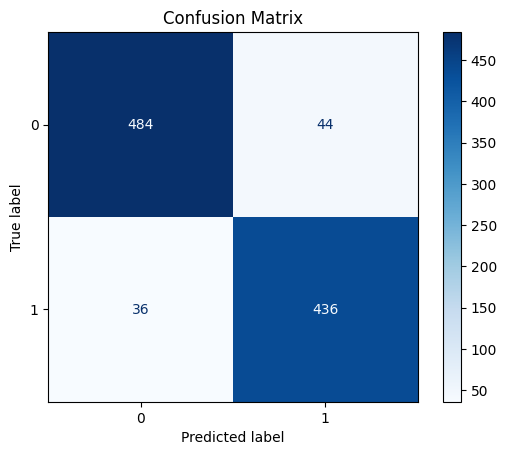

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming `trainer` is your trained model and `tokenized_datasets["test"]` is the test set
predictions = trainer.predict(tokenized_datasets["test"])

# Extract predicted labels and true labels
y_pred = np.argmax(predictions.predictions, axis=1)  # Predicted labels
y_true = predictions.label_ids  # True labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
